In [1]:
# !pip install torch torchvision transformers datasets pillow pandas numpy
# !pip install jsonlines
# !pip install scikit-learn


In [2]:

from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
import jsonlines
import os

from collections import Counter
import re

### Download data from https://www.kaggle.com/datasets/parthplc/facebook-hateful-meme-dataset?resource=download

In [3]:
DATA_DIR = "data"
def load_jsonl(filename):
    path = os.path.join(DATA_DIR, filename)
    with jsonlines.open(path) as reader:
        return pd.DataFrame(reader)

In [4]:
train_df = load_jsonl("train.jsonl")
dev_df = load_jsonl("dev.jsonl")
test_df = load_jsonl("test.jsonl")

In [5]:
print("Train shape:", train_df.shape)
print("Dev shape:", dev_df.shape)
print("Test shape:", test_df.shape)

Train shape: (8500, 4)
Dev shape: (500, 4)
Test shape: (1000, 3)


In [6]:
print("\nSample record:")
print(train_df.iloc[0])


Sample record:
id                                                  42953
img                                         img/42953.png
label                                                   0
text     its their character not their color that matters
Name: 0, dtype: object


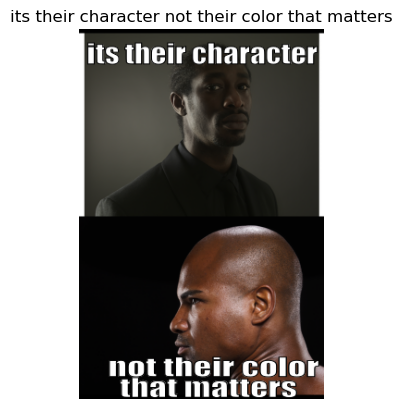

In [7]:
img_path = os.path.join(DATA_DIR, "", train_df.iloc[0]['img'])
img = Image.open(img_path)

plt.imshow(img)
plt.title(train_df.iloc[0]['text'])
plt.axis('off')
plt.show()


Label Distribution (Train):
label
0    0.641176
1    0.358824
Name: proportion, dtype: float64


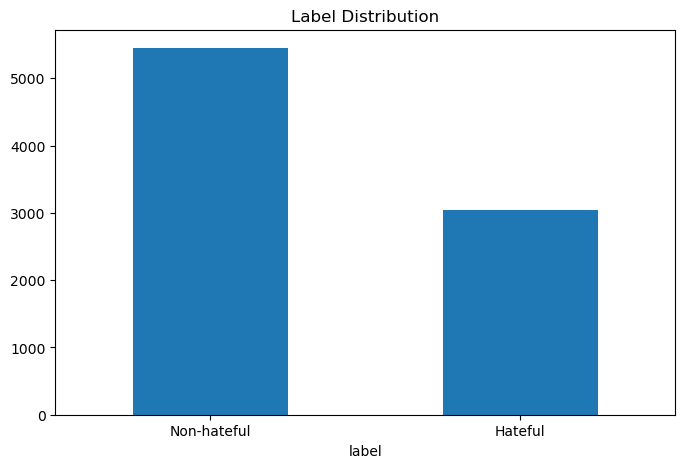

In [8]:
print("\nLabel Distribution (Train):")
print(train_df['label'].value_counts(normalize=True))

plt.figure(figsize=(8, 5))
train_df["label"].value_counts().plot(kind="bar")
plt.title("Label Distribution")
plt.xticks([0, 1], ["Non-hateful", "Hateful"], rotation=0)
plt.show()

In [9]:
print("\nLabel Distribution (Dev):")
print(dev_df['label'].value_counts(normalize=True))


Label Distribution (Dev):
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [10]:
print("\nMissing values (Train):")
print(train_df.isnull().sum())


Missing values (Train):
id       0
img      0
label    0
text     0
dtype: int64


In [11]:
print("\nDuplicate rows (Train):", train_df.duplicated().sum())


Duplicate rows (Train): 0


In [12]:
train_df[['id', 'img', 'text', 'label']].head()

,id,img,text,label
0,42953,img/42953.png,its their character not their color that matters,0
1,23058,img/23058.png,don't be afraid to love again everyone is not ...,0
2,13894,img/13894.png,putting bows on your pet,0
3,37408,img/37408.png,i love everything and everybody! except for sq...,0
4,82403,img/82403.png,"everybody loves chocolate chip cookies, even h...",0


In [13]:
train_df['text_length'] = train_df['text'].apply(len)
print("\nText Length Summary (Train):")
print(train_df['text_length'].describe())


Text Length Summary (Train):
count    8500.000000
mean       62.075765
std        37.035517
min         4.000000
25%        37.000000
50%        54.000000
75%        78.000000
max       433.000000
Name: text_length, dtype: float64


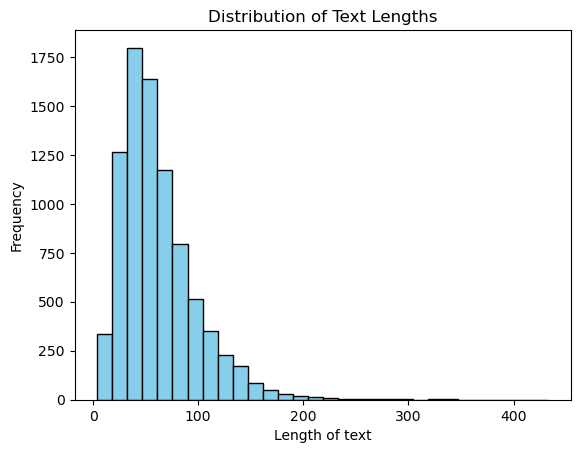

In [14]:
plt.hist(train_df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Text Lengths")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

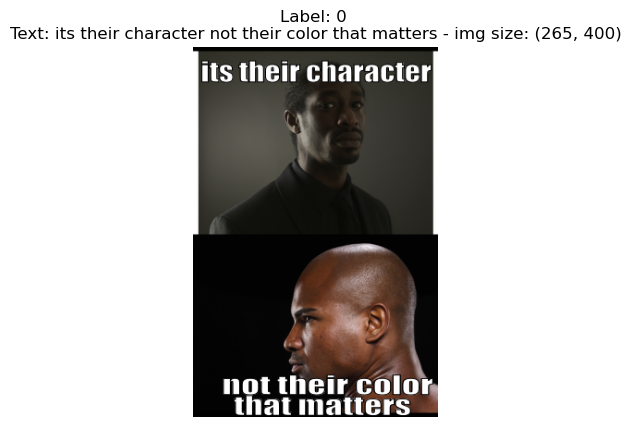

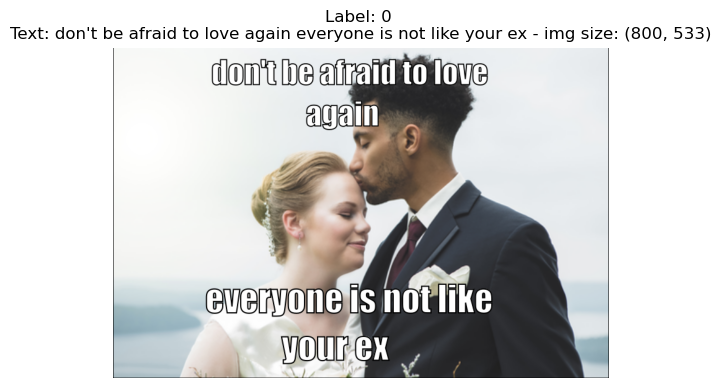

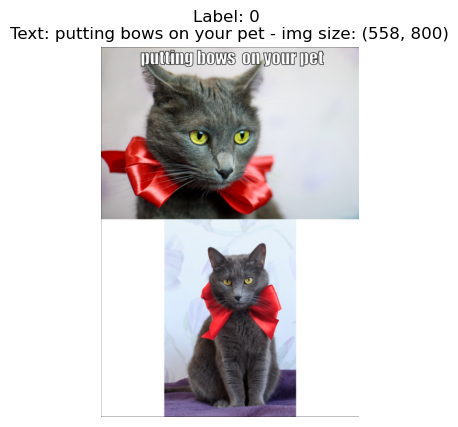

In [15]:
def show_sample(idx):
    row = train_df.iloc[idx]
    # img_path = os.path.join(DATA_DIR, "img", row["img"])
    img_path = os.path.join(DATA_DIR, row["img"])
    img = Image.open(img_path).convert('RGB')
    size = img.size
    plt.imshow(img)
    plt.title(f"Label: {row['label']} \nText: {row['text']} - img size: {size}")
    plt.axis('off')
    plt.show()

# View a few samples
for i in [0, 1, 2]:
    show_sample(i)

In [16]:
def clean_text(text):
    return re.findall(r'\b\w+\b', text.lower())

# Token frequency by label
hateful_words = Counter()
non_hateful_words = Counter()

for _, row in train_df.iterrows():
    words = clean_text(row['text'])
    if row['label'] == 1:
        hateful_words.update(words)
    else:
        non_hateful_words.update(words)

print("\nTop 10 words in hateful memes:")
print(hateful_words.most_common(10))

print("\nTop 10 words in non-hateful memes:")
print(non_hateful_words.most_common(10))


Top 10 words in hateful memes:
[('the', 1283), ('you', 1114), ('a', 1075), ('i', 921), ('to', 791), ('and', 635), ('when', 504), ('of', 487), ('is', 482), ('in', 473)]

Top 10 words in non-hateful memes:
[('you', 2060), ('the', 1848), ('i', 1633), ('a', 1608), ('to', 1421), ('when', 874), ('and', 853), ('is', 781), ('in', 741), ('your', 718)]


## Data Class for hugging face/pytorch

In [17]:
import torch
from torch.utils.data import Dataset

class HatefulMemesDataset(Dataset):
    def __init__(self, dataframe, img_dir, tokenizer, transform=None, max_length=128):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.img_dir, row['img'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        else:
            image = image  #  PIL for CLIP

        # Tokenize text
        encoded = self.tokenizer(
            row['text'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'pixel_values': image,
            'label': torch.tensor(row['label'], dtype=torch.long)
        }


## check if custom data class is working

In [18]:
from transformers import AutoTokenizer
from torchvision import transforms

DATA_IMG_DIR = "data"
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Instantiate dataset
test_dataset = HatefulMemesDataset(
    dataframe=train_df,
    img_dir=DATA_IMG_DIR,
    tokenizer=tokenizer,
    transform=image_transform
)

# Test one sample
sample = test_dataset[0]

print("Input IDs shape:", sample['input_ids'].shape)
print("Attention mask shape:", sample['attention_mask'].shape)
print("Image shape:", sample['pixel_values'].shape)
print("Label:", sample['label'])


Input IDs shape: torch.Size([128])
Attention mask shape: torch.Size([128])
Image shape: torch.Size([3, 224, 224])
Label: tensor(0)


In [19]:
from transformers import AutoTokenizer
from torchvision import transforms


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define image transform
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset objects
train_dataset = HatefulMemesDataset(
    dataframe=train_df,
    img_dir=DATA_IMG_DIR,
    tokenizer=tokenizer,
    transform=None  # for clip
)

dev_dataset = HatefulMemesDataset(
    dataframe=dev_df,
    img_dir=DATA_IMG_DIR,
    tokenizer=tokenizer,
    transform=None # for clip
)


In [21]:
sample = train_dataset[0]
print("Image shape      :", sample["pixel_values"].size)
print("Input IDs shape  :", sample["input_ids"].size)
print("Label            :", sample["label"])

Image shape      : (265, 400)
Input IDs shape  : <built-in method size of Tensor object at 0x000001D88DDD89A0>
Label            : tensor(0)


In [22]:
from transformers import CLIPProcessor, CLIPModel

# Load model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [23]:
candidate_labels = ["a hateful meme", "a non-hateful meme"]


In [24]:
# Correct label text mapping
id2label = {1: "a hateful meme", 0: "a non-hateful meme"}

for i in range(5):
    sample = train_dataset[i]
    image = sample["pixel_values"]
    actual_label = sample["label"].item()
    text = train_df.iloc[i]["text"]  # ← this is the fix

    inputs = clip_processor(
        text=candidate_labels,
        images=image,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = clip_model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=1)

    pred_label = probs.argmax().item()
    confidence = probs[0][pred_label].item()

    print(f"Sample #{i}")
    print(f"Text           : {text}")
    print(f"Actual Label   : {id2label[actual_label]}")
    print(f"Predicted Label: {candidate_labels[pred_label]} (confidence: {confidence:.2f})")
    print("-" * 60)


Sample #0
Text           : its their character not their color that matters
Actual Label   : a non-hateful meme
Predicted Label: a hateful meme (confidence: 0.53)
------------------------------------------------------------
Sample #1
Text           : don't be afraid to love again everyone is not like your ex
Actual Label   : a non-hateful meme
Predicted Label: a non-hateful meme (confidence: 0.82)
------------------------------------------------------------
Sample #2
Text           : putting bows on your pet
Actual Label   : a non-hateful meme
Predicted Label: a non-hateful meme (confidence: 0.52)
------------------------------------------------------------
Sample #3
Text           : i love everything and everybody! except for squirrels i hate squirrels
Actual Label   : a non-hateful meme
Predicted Label: a hateful meme (confidence: 0.50)
------------------------------------------------------------
Sample #4
Text           : everybody loves chocolate chip cookies, even hitler
Actual La

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_true = []
y_pred = []

for i in range(len(dev_dataset)):
    sample = dev_dataset[i]
    image = sample["pixel_values"]
    actual_label = sample["label"].item()
    text = dev_df.iloc[i]["text"]

    # Zero-shot prediction
    inputs = clip_processor(
        text=candidate_labels,
        images=image,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = clip_model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=1)
        pred_label = probs.argmax().item()

    y_true.append(actual_label)
    y_pred.append(pred_label)

# Evaluate
print("Zero-shot CLIP Evaluation on Dev Set:")
print("Accuracy :", accuracy_score(y_true, y_pred))
print("F1 Score :", f1_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))


Zero-shot CLIP Evaluation on Dev Set:
Accuracy : 0.514
F1 Score : 0.5929648241206029
Precision: 0.5100864553314121
Recall   : 0.708


## Fine tune

In [ ]:
# pip install transformers datasets torchvision accelerate
# ! pip install --upgrade transformers
import transformers
print(transformers.__version__)

4.46.3


In [ ]:
from transformers import CLIPProcessor, CLIPModel

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
import torch
import torch.nn as nn

class CLIPForClassification(nn.Module):
    def __init__(self, clip_model, hidden_size=512):
        super().__init__()
        self.clip = clip_model
        # Projection dimension from the CLIP model
        self.proj_dim = clip_model.config.projection_dim  
        # Classifier head: concatenated embeddings from image and text
        self.classifier = nn.Sequential(
            nn.Linear(self.proj_dim * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)  # Binary classification (2 classes)
        )
        
    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Pass data through CLIP to get embeddings
        outputs = self.clip(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            pixel_values=pixel_values
        )
        text_embeds = outputs.text_embeds  # Shape: (batch, proj_dim)
        image_embeds = outputs.image_embeds  # Shape: (batch, proj_dim)
        # Concatenate image and text embeddings along the last dimension
        combined = torch.cat([text_embeds, image_embeds], dim=1)
        logits = self.classifier(combined)
        
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        return {"logits": logits, "loss": loss}


----------

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, TrainingArguments, Trainer

In [ ]:
class HatefulMemesDataset(Dataset):
    def __init__(self, dataframe, img_dir, tokenizer, transform=None, max_length=128):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image from the given directory
        img_path = os.path.join(self.img_dir, row['img'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # If no transform is given, we leave it as a PIL image so that CLIPProcessor can handle it.

        # Tokenize the text using the provided tokenizer.
        encoded = self.tokenizer(
            row['text'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'pixel_values': image,
            'labels': torch.tensor(row['label'], dtype=torch.long)  # key renamed to "labels"
        }


In [ ]:
data_dir = "data"       
img_dir = data_dir    


In [ ]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
base_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
class CLIPForClassification(nn.Module):
    def __init__(self, clip_model, hidden_size=512):
        super().__init__()
        self.clip = clip_model
        # Get the projection dimension from the base CLIP model.
        self.proj_dim = clip_model.config.projection_dim  
        # Define a simple classifier head that takes concatenated text and image embeddings.
        self.classifier = nn.Sequential(
            nn.Linear(self.proj_dim * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)  # Binary classification (2 classes)
        )
        
    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Pass through CLIP to get text and image embeddings.
        outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        text_embeds = outputs.text_embeds  # Shape: (batch, proj_dim)
        image_embeds = outputs.image_embeds  # Shape: (batch, proj_dim)
        # Concatenate the embeddings.
        combined = torch.cat([text_embeds, image_embeds], dim=1)
        logits = self.classifier(combined)
        
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        return {"logits": logits, "loss": loss}


In [ ]:
model = CLIPForClassification(clip_model=base_clip, hidden_size=512)

In [ ]:
train_dataset = HatefulMemesDataset(train_df, img_dir, tokenizer=processor.tokenizer, transform=None)
dev_dataset   = HatefulMemesDataset(dev_df, img_dir, tokenizer=processor.tokenizer, transform=None)


In [ ]:
training_args = TrainingArguments(
    output_dir="./clip_finetune_results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=20,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    # You can optionally pass a data collator if needed.
)

In [ ]:
trainer.train()

results = trainer.evaluate()
print("Evaluation Results:", results)

  0%|          | 0/3189 [00:00<?, ?it/s]

RuntimeError: Could not infer dtype of Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# !pip install wandb
# !pip install peft
# os.environ["WANDB_MODE"] = "offline"
# os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import os
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from transformers import (
    CLIPProcessor,
    CLIPModel,
    TrainingArguments,
    Trainer
)
from transformers import EarlyStoppingCallback

import random
import numpy as np
import torch
from transformers import set_seed
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training


seed = 42
set_seed(seed)         # sets seed for transformers as well

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

from scipy.special import softmax

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    # Compute probabilities for the positive class using softmax.
    probs = softmax(logits, axis=1)[:, 1]
    auc = roc_auc_score(labels, probs)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }

# -------------------------------
# 1. Define the Custom Dataset
# -------------------------------
class HatefulMemesDataset(Dataset):
    def __init__(self, dataframe, img_dir, tokenizer, transform=None, max_length=77):
        # Set max_length=77 for CLIP
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image and convert to RGB
        img_path = os.path.join(self.img_dir, row['img'])
        image = Image.open(img_path).convert('RGB')
        # Apply transform so that image is a tensor
        if self.transform:
            image = self.transform(image)
        # Tokenize text using the provided tokenizer with max_length=77
        encoded = self.tokenizer(
            row['text'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'pixel_values': image,
            'labels': torch.tensor(row['label'], dtype=torch.long)
        }

# -------------------------------
# 2. Set Up Directories and Processor
# -------------------------------
data_dir = Path("data")
img_dir = data_dir  # adjust if your images are in a subfolder

# Load the CLIP processor and base model.
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
base_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# -------------------------------
# 3. Define the Custom CLIP Classification Model
# -------------------------------
class CLIPForClassification(nn.Module):
    def __init__(self, clip_model, hidden_size=512, dropout_rate=0.1):
        super().__init__()
        self.clip = clip_model
        self.proj_dim = clip_model.config.projection_dim  
        self.classifier = nn.Sequential(
            nn.Linear(self.proj_dim * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Added dropout
            nn.Linear(hidden_size, 2)
        )
        
    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        outputs = self.clip(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            pixel_values=pixel_values
        )
        text_embeds = outputs.text_embeds  
        image_embeds = outputs.image_embeds  
        combined = torch.cat([text_embeds, image_embeds], dim=1)
        logits = self.classifier(combined)
        
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        return {"logits": logits, "loss": loss}
    
    def state_dict(self, *args, **kwargs):
        state = super().state_dict(*args, **kwargs)
        # Force any non-contiguous tensor to be contiguous
        for key, value in state.items():
            if isinstance(value, torch.Tensor) and not value.is_contiguous():
                state[key] = value.contiguous()
        return state


model = CLIPForClassification(clip_model=base_clip, hidden_size=2048,dropout_rate=0.1)
model.to(device)
for param in model.clip.parameters():
    param.requires_grad = False

# Unfreeze the final layer in the text encoder
# for param in model.clip.text_model.encoder.layers[-1].parameters():
#     param.requires_grad = True

# # Unfreeze the final layer in the vision encoder
# for param in model.clip.vision_model.encoder.layers[-1].parameters():
#     param.requires_grad = True

for layer in model.clip.text_model.encoder.layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True
for layer in model.clip.vision_model.encoder.layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

# for param in model.clip.text_model.text_projection.parameters():
#     param.requires_grad = True

# Unfreeze vision projection layer
# for param in model.clip.vision_model.visual_projection.parameters():
#     param.requires_grad = True
# -------------------------------
# 4. Define Image Transform for Fine-Tuning
# -------------------------------
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_processor.image_mean, 
                         std=processor.image_processor.image_std)
])

# -------------------------------
# 5. Create Dataset Objects for Training and Evaluation
# -------------------------------
# Set max_length to 77 here as well.
train_dataset = HatefulMemesDataset(train_df, img_dir, tokenizer=processor.tokenizer, transform=image_transform, max_length=77)
dev_dataset   = HatefulMemesDataset(dev_df, img_dir, tokenizer=processor.tokenizer, transform=image_transform, max_length=77)

# -------------------------------
# 6. Set Up the Trainer
# -------------------------------
training_args = TrainingArguments(
    output_dir="./clip_finetune_results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=20,
    max_grad_norm=1.0,  # Gradient clipping
    learning_rate=1e-4,  # Adding explicit learning rate
    weight_decay=0.1,   # L2 regularization
    # lr_scheduler_type="cosine",
    lr_scheduler_type="constant",
    load_best_model_at_end=True,  # Load best model at the end
    # metric_for_best_model="f1",   # Optimize for F1 score
    warmup_steps=100,             # Gradual warmup
    # fp16=True,               
    report_to="tensorboard",
    # run_name="clip-finetune-local",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# -------------------------------
# 7. Fine-Tune and Evaluate
# -------------------------------
trainer.train()
results = trainer.evaluate()
trainer.log_metrics("eval", results)
trainer.save_metrics("eval", results)

print("Evaluation Results:", results)


###########
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="./logs/hparams")

# Define your hyperparameters
hparams = {
    "model": "CLIP-vit-base",
    "batch_size": training_args.per_device_train_batch_size,
    "learning_rate": training_args.learning_rate,
    "weight_decay": training_args.weight_decay,
    "epochs": training_args.num_train_epochs,
    "hidden_size": 2048,
    "dropout": 0.1,
    "unfrozen_text_layers": 3,
    "unfrozen_vision_layers": 3,
    "warmup_steps": training_args.warmup_steps,
    "fp16": training_args.fp16,
    "max_grad_norm": training_args.max_grad_norm
}

# Log final metrics (already computed)
metrics = {
    "accuracy": results["eval_accuracy"],
    "precision": results["eval_precision"],
    "recall": results["eval_recall"],
    "f1": results["eval_f1"],
    "auc": results["eval_auc"]
}

# Log to TensorBoard
writer.add_hparams(hparams, metrics)
writer.close()



c:\Users\baljeet\.conda\envs\cs7643-a3-nlp\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/399 [00:00<?, ?it/s]

{'loss': 0.6624, 'grad_norm': 0.29234474897384644, 'learning_rate': 0.0001, 'epoch': 0.15}
{'loss': 0.5832, 'grad_norm': 0.8372231721878052, 'learning_rate': 0.0001, 'epoch': 0.3}
{'loss': 0.582, 'grad_norm': 0.9515290260314941, 'learning_rate': 0.0001, 'epoch': 0.45}
{'loss': 0.5384, 'grad_norm': 0.978139340877533, 'learning_rate': 0.0001, 'epoch': 0.6}
{'loss': 0.5457, 'grad_norm': 0.8927709460258484, 'learning_rate': 0.0001, 'epoch': 0.75}
{'loss': 0.556, 'grad_norm': 0.9016636610031128, 'learning_rate': 0.0001, 'epoch': 0.9}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.858545184135437, 'eval_accuracy': 0.562, 'eval_precision': 0.7066666666666667, 'eval_recall': 0.212, 'eval_f1': 0.3261538461538461, 'eval_auc': 0.638504, 'eval_runtime': 6.4685, 'eval_samples_per_second': 77.297, 'eval_steps_per_second': 1.237, 'epoch': 1.0}
{'loss': 0.4934, 'grad_norm': 0.8968933820724487, 'learning_rate': 0.0001, 'epoch': 1.05}
{'loss': 0.4712, 'grad_norm': 1.4250341653823853, 'learning_rate': 0.0001, 'epoch': 1.2}
{'loss': 0.4875, 'grad_norm': 1.985141634941101, 'learning_rate': 0.0001, 'epoch': 1.35}
{'loss': 0.4681, 'grad_norm': 0.999212384223938, 'learning_rate': 0.0001, 'epoch': 1.5}
{'loss': 0.4666, 'grad_norm': 1.528557538986206, 'learning_rate': 0.0001, 'epoch': 1.65}
{'loss': 0.4772, 'grad_norm': 1.3099557161331177, 'learning_rate': 0.0001, 'epoch': 1.8}
{'loss': 0.508, 'grad_norm': 1.21499502658844, 'learning_rate': 0.0001, 'epoch': 1.95}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8455342650413513, 'eval_accuracy': 0.562, 'eval_precision': 0.691358024691358, 'eval_recall': 0.224, 'eval_f1': 0.338368580060423, 'eval_auc': 0.645832, 'eval_runtime': 6.6559, 'eval_samples_per_second': 75.121, 'eval_steps_per_second': 1.202, 'epoch': 2.0}
{'loss': 0.4092, 'grad_norm': 1.0060904026031494, 'learning_rate': 0.0001, 'epoch': 2.11}
{'loss': 0.3699, 'grad_norm': 2.371466875076294, 'learning_rate': 0.0001, 'epoch': 2.26}
{'loss': 0.3499, 'grad_norm': 2.5009605884552, 'learning_rate': 0.0001, 'epoch': 2.41}
{'loss': 0.3476, 'grad_norm': 1.7736929655075073, 'learning_rate': 0.0001, 'epoch': 2.56}
{'loss': 0.3488, 'grad_norm': 2.526693105697632, 'learning_rate': 0.0001, 'epoch': 2.71}
{'loss': 0.3651, 'grad_norm': 1.3099710941314697, 'learning_rate': 0.0001, 'epoch': 2.86}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9271581768989563, 'eval_accuracy': 0.588, 'eval_precision': 0.7, 'eval_recall': 0.308, 'eval_f1': 0.42777777777777776, 'eval_auc': 0.6499039999999998, 'eval_runtime': 6.5733, 'eval_samples_per_second': 76.065, 'eval_steps_per_second': 1.217, 'epoch': 3.0}
{'train_runtime': 354.947, 'train_samples_per_second': 71.842, 'train_steps_per_second': 1.124, 'train_loss': 0.47034797453342525, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =      0.562
  eval_auc                =     0.6458
  eval_f1                 =     0.3384
  eval_loss               =     0.8455
  eval_precision          =     0.6914
  eval_recall             =      0.224
  eval_runtime            = 0:00:06.25
  eval_samples_per_second =     79.938
  eval_steps_per_second   =      1.279
Evaluation Results: {'eval_loss': 0.8455342650413513, 'eval_accuracy': 0.562, 'eval_precision': 0.691358024691358, 'eval_recall': 0.224, 'eval_f1': 0.338368580060423, 'eval_auc': 0.645832, 'eval_runtime': 6.2548, 'eval_samples_per_second': 79.938, 'eval_steps_per_second': 1.279, 'epoch': 3.0}


In [ ]:
type(training_args.per_device_train_batch_size)
type(training_args.fp16)

bool

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use trainer.predict() on the dev dataset
predictions_output = trainer.predict(dev_dataset)

# Extract predicted logits and true labels
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted labels (argmax across the two classes)
pred_labels = np.argmax(logits, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print("Evaluation Metrics on Dev Set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


  0%|          | 0/16 [00:00<?, ?it/s]

Evaluation Metrics on Dev Set:
Accuracy:  0.5520
F1 Score:  0.3293
Precision: 0.6548
Recall:    0.2200
